In [97]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Value
Similar to Tensor, lets call it the engine of our Neural Net

In [98]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward

        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

## Visualization using Graphviz

In [99]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Example NN-1

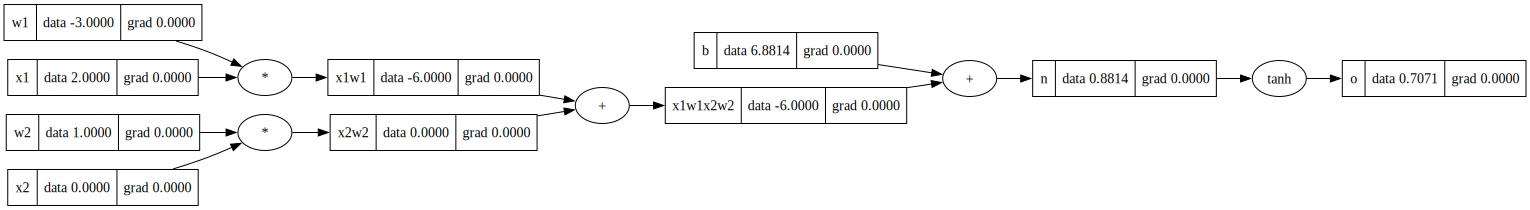

In [100]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)
    

### Single Backward Pass on NN1

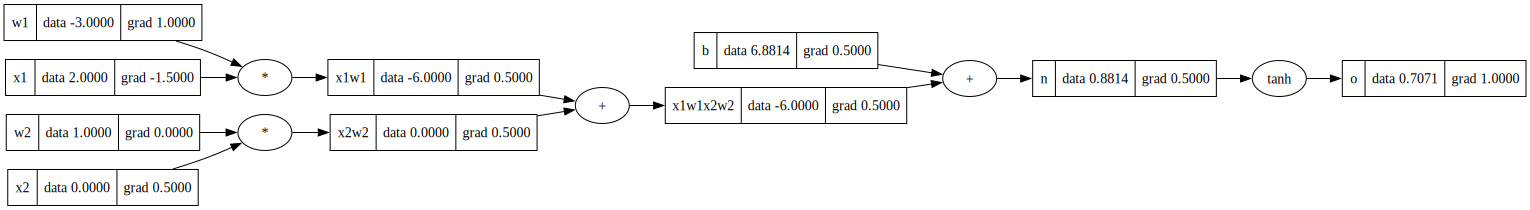

In [101]:
o.backward()
draw_dot(o)

## Showcasing how Value is similar to Tensor

In [102]:
import torch

In [103]:
x1 = torch.Tensor([2.0]).double()               ;x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ;w1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ;x2.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ;b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('w2', w2.grad.item())
print('x2', x2.grad.item())
print('w1', w2.grad.item())
print('x1', x1.grad.item())


0.7071066904050358
-----
w2 0.0
x2 0.5000001283844369
w1 0.0
x1 -1.5000003851533106


## Building the Neural Net Model

In [104]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(1, -1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(1, -1)); self.b.label = 'b'

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## Example NN-2

In [105]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8562116765190876)

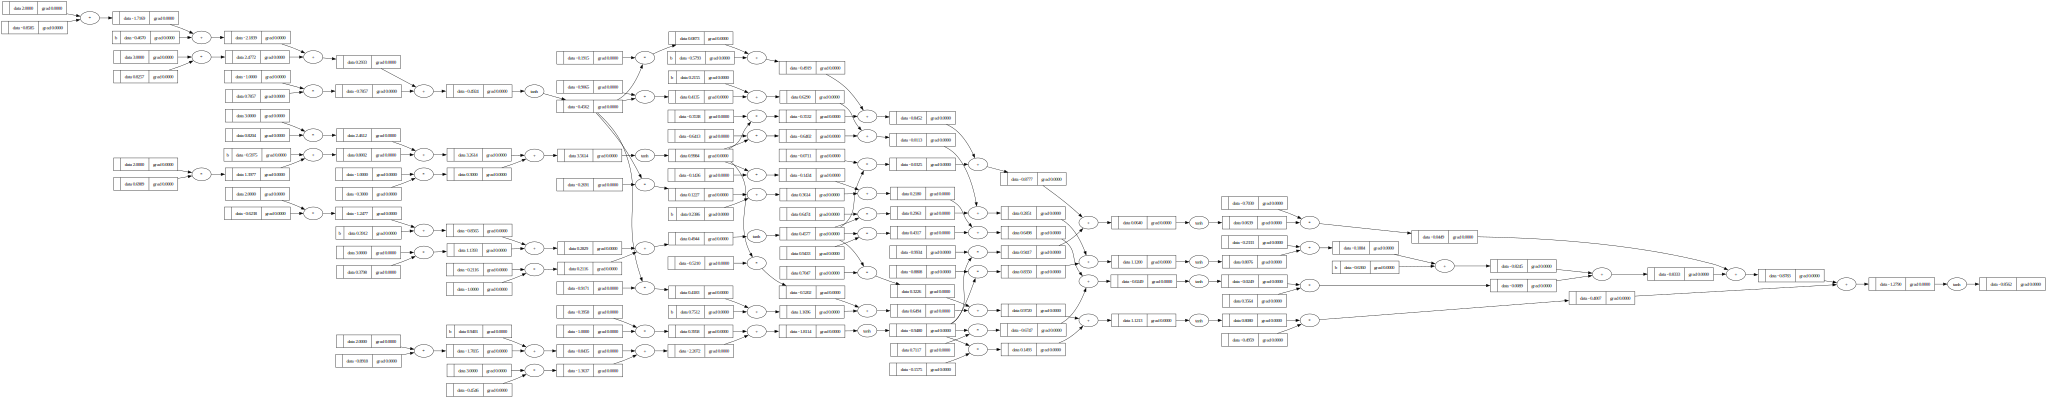

In [106]:
draw_dot(n(x))

## Example NN-3

In [107]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1,0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### Training for 20 spochs 

In [108]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for yout, ygt in zip(ypred, ys))

    #backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)






0 6.624779706076542
1 5.0221831742446685
2 2.720903638294704
3 2.0617413305994097
4 1.4607768177139366
5 0.9201919666416285
6 0.5775311733706238
7 0.3931766491940235
8 0.2901562303697577
9 0.2268906190182927
10 0.18481110793424896
11 0.15508770390728682
12 0.13310772732808285
13 0.11626451412674901
14 0.10298671746879577
15 0.09227598132810653
16 0.08347002388149102
17 0.07611344539387076
18 0.06988348252767757
19 0.06454539582825397


In [109]:
ypred

[Value(data=0.9111046486488896),
 Value(data=-0.9245036573717076),
 Value(data=-0.8581309363595674),
 Value(data=0.8244537571807503)]